<a href="https://colab.research.google.com/github/durml91/Personal/blob/main/Transformer_implementation_III%20-%20New%20features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Transformer (Encoder-Decoder) Implementation**

## Installs and Imports

*Nvidia CUDA version check*

In [ ]:
# !nvcc --version
# !cat /usr/local/cuda/version.txt
# !cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

**Install datasets before updating JAX**

In [1]:
!pip install datasets[jax]
!pip install tokenizers
!pip install transformers
!pip install einops
!pip install equinox
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.2/71.2 MB 14.4 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.3.25-py3-none-any.whl size=1308495 sha256=5b9caa8c62e408497e9a8e44ff22a41024487ed4f75a54ec85167bc2813b8804
  Stored in directory: /root/.cache/pip/wheels/41/0b/45/1acffcaf4c863a6d0d0e910e56ae6502ca8d16300e39e1dab2
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.13+cuda11.cudnn86
    Uninstalling jaxlib-

In [2]:
!pip install jaxlib==0.4.13+cuda11.cudnn86 -f  https://storage.googleapis.com/jax-releases/jax_cuda_releases.html # [cuda]

#!pip install -U jax jaxlib # [cpu]

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 7.2 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.25
    Uninstalling jaxlib-0.3.25:
      Successfully uninstalled jaxlib-0.3.25


*Restart runtime here!*

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp

import einops

import equinox as eqx

import optax

import tqdm
from tqdm import notebook as tqdm

import functools

from typing import Dict, List, Mapping, Optional, Callable
from jaxtyping import Array, Float, Int

import math

import numpy as np

import datasets
from datasets import load_dataset

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from matplotlib.pylab import plt

from torchmetrics.text import WordErrorRate, CharErrorRate, BLEUScore
from torch.utils import data

*Check VM is using GPU accelerator*

In [ ]:
jax.default_backend()

'gpu'

**Random key generation**

In [2]:
rand_key = jr.PRNGKey(2023)

## **Transformer**

### Transformer modules

**Generic equinox module for GELU**

In [3]:
class Lambda(eqx.Module):

    fn: Callable

    def __call__(self, x, *, key=None):
        return self.fn(x)

**Attention**

In [4]:
# causal_attention_mask(jnp.array([2, 3])) == None

In [5]:
# def causal_attention_mask(x):
#     dim = x.shape[0]

#     mask = jnp.ones((dim, dim), dtype=float)
#     mask = jnp.tril(mask, k=0)
#     return mask == 1

In [6]:
class AttentionBlock(eqx.Module):

    attention: eqx.nn.MultiheadAttention
    dropout: eqx.nn.Dropout
    num_heads: int = eqx.field(static=True)

    def __init__(
        self,
        d_model: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        self.num_heads = num_heads
        self.attention = eqx.nn.MultiheadAttention(
            num_heads=num_heads,
            query_size=d_model,
            use_query_bias=True,
            use_key_bias=True,
            use_value_bias=True,
            use_output_bias=True,
            dropout_p=attention_dropout_rate,
            key=key,
        )

        self.dropout = eqx.nn.Dropout(dropout_rate)

    @eqx.filter_jit
    def causal_attention_mask(self, q_shape, kv_shape, pad: bool):
        if pad == True:
            #print("causal - padding")
            mask = jnp.ones((q_shape, kv_shape), dtype=float)
            mask = jnp.tril(mask, k=0)
            return mask == 1
        else:
            #print("causal - no padding")
            mask = jnp.ones((q_shape, kv_shape), dtype=float)
            mask = jnp.tril(mask, k=0) == 1
            mask = jnp.expand_dims(mask, axis=-3)
            mask = jnp.where(mask, 1.0, 0.0)
            return jnp.repeat(mask, repeats=self.num_heads, axis=-3)


    @eqx.filter_jit
    def make_attention_mask(
        self, q_pad_mask: Array = jnp.array(()), kv_pad_mask: Array = jnp.array(()), look_ahead_mask: bool = False, inf_shape: int = None
    ) -> Float[Array, "num_heads query_seq_len kv_seq_len"]:

        if q_pad_mask is None:
            #print("cross attn for inf")
            mask = einops.repeat(kv_pad_mask, " a b -> (a q) b", q = inf_shape)
            mask = jnp.where(mask, 1.0, 0.0)
            mask = jnp.expand_dims(mask, axis=-3)
            mask = jnp.repeat(mask, repeats=self.num_heads, axis=-3)
            return mask

        # creates rectangular padding with q_pad_mask on the vertical and kv_pad_mask on the horizontal!
        padding_mask = jnp.multiply(jnp.expand_dims(q_pad_mask, axis=-1), jnp.expand_dims(kv_pad_mask, axis=-2))
        p_mask = jnp.where(padding_mask, 1.0, 0.0)
        p_mask = jnp.repeat(p_mask, repeats=self.num_heads, axis=-3)
        if look_ahead_mask is True:
            q_shape = q_pad_mask.shape[-1]
            kv_shape = kv_pad_mask.shape[-1]
            cross_attn_mask = padding_mask & jnp.expand_dims(self.causal_attention_mask(q_shape, kv_shape, pad = True), axis=-3)
            cross_attn_mask = jnp.where(cross_attn_mask, 1.0, 0.0)
            cross_attn_mask = jnp.repeat(cross_attn_mask, repeats=self.num_heads, axis=-3)
            return cross_attn_mask   # .astype(jnp.float32)
        else:
            return p_mask  # .astype(jnp.float32)

    def __call__(
        self,
        query: Float[Array, "... d_model"],
        key_: Float[Array, "... d_model"],
        value: Float[Array, "... d_model"],
        q_pad_mask: Array = None,
        kv_pad_mask: Array = None,
        look_ahead_mask: bool = False,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "... d_model"]:


        if q_pad_mask is not None and kv_pad_mask is not None:
            #print("train")
            mask = self.make_attention_mask(q_pad_mask, kv_pad_mask, look_ahead_mask)
        elif q_pad_mask is None and look_ahead_mask == True:
            #print("self_attn - inference")
            mask = self.causal_attention_mask(query.shape[-2], key_.shape[-2], pad = False)
        elif q_pad_mask is None and kv_pad_mask is not None:
            #print("cross_attn - inference")
            mask = self.make_attention_mask(q_pad_mask, kv_pad_mask, inf_shape = query.shape[-2])
        else:
            #print("none")
            mask = None

        #print(mask)
        #print(jnp.sum(mask))


        attention_key, dropout_key = (
            (None, None) if key is None else jr.split(key)
        )

        attention_output = self.attention(
              query=query,
              key_=key_,
              value=value,
              mask=mask,
              inference=not enable_dropout,
              key=attention_key
        )

        att_drop = self.dropout(attention_output, inference=not enable_dropout, key=dropout_key)

        return att_drop

In [7]:
# jnp.multiply(jnp.expand_dims(jnp.array([[True, True, True, True, True]]), axis=-1), jnp.expand_dims(jnp.array([[True, True, True, True, True]]), axis=-2))

In [8]:
# jnp.multiply(jnp.expand_dims(jnp.array([[True, True, True, False, False]]), axis=-1), jnp.expand_dims(jnp.array([[True, True, True, True, False]]), axis=-2))

In [9]:
# jnp.multiply(jnp.expand_dims(jnp.array([[True, True, True, False, False]]), axis=-1), jnp.expand_dims(jnp.array([[True, True, True, False, False]]), axis=-2)) & causal_attention_mask(jnp.array([True,True,True,False,False]))

In [10]:
# causal_attention_mask(jnp.array([True,True,True,False,False]))

*Below is a breakdown of how the attention mask is actually used in equinox*

In [11]:
# logits = jr.normal(rand_key, shape=(10,10))

# mask = jnp.ones((10,10))
# mask = jnp.tril(mask, k=0)

# #mask = jnp.where(mask==1., -jnp.inf, mask)

# print(mask)
# print(logits)
# logits1 = jnp.where(mask, logits, jnp.finfo(logits.dtype).min)
# print(logits1)
# logits2 = jnp.where(mask==1, logits, jnp.finfo(logits.dtype).min)
# #print(logits2)

# print(logits1 - logits2)

**MLP Block**

In [12]:
class FeedForwardBlock(eqx.Module):

    mlp: eqx.nn.Sequential    #could also use MLP if this way is more fiddly
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        dropout_rate: float,
        key: jr.PRNGKey,
    ):
        linear1, linear2 = jr.split(key)

        self.mlp = eqx.nn.Sequential([
            eqx.nn.Linear(in_features=d_model, out_features=intermediate_size, key=linear1),
            Lambda(jax.nn.gelu),
            eqx.nn.Linear(in_features=intermediate_size, out_features=d_model, key=linear2)
        ])
        self.dropout = eqx.nn.Dropout(dropout_rate)

    def __call__(
        self,
        inputs: Float[Array, "... d_model"],
        enable_dropout: bool = True,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        feed_out = jax.vmap(self.mlp)(inputs)
        out_d = self.dropout(feed_out, inference=not enable_dropout, key=key)

        return out_d


**Embedding table**

In [13]:
class InputEmbeddings(eqx.Module):

  embedding: eqx.nn.Embedding
  d_model: int

  def __init__(
      self,
      d_model: int,
      vocab_size: int,
      key: jr.PRNGKey,
  ):
      self.d_model = d_model
      self.embedding = eqx.nn.Embedding(vocab_size, d_model, key=key)

  def __call__(self, x) -> Float[Array, "seq_len d_model"]:

    return self.embedding(x) * math.sqrt(self.d_model)

**Positional encoding**

In [14]:
class SinusoidalPosEmb(eqx.Module):
    pos_emb: jax.Array
    dropout: eqx.nn.Dropout

    def __init__(
        self,
        d_model: int,
        seq_len: int,
        dropout_rate: float
    ):
        self.dropout = eqx.nn.Dropout(dropout_rate)
        half_dim = d_model//2
        pe = jnp.zeros((seq_len, d_model))
        position = einops.repeat(jnp.arange(0 , seq_len), " s -> s r", r=half_dim)  #shape [seq_len, d_model/2]
        div_term = jnp.exp(jnp.arange(0, d_model, 2) * -(math.log(10_000) / d_model))  #shape [d_model/2]
        ins = jax.vmap(jnp.multiply, in_axes=(1, 0), out_axes=1)(position, div_term)  #shape [seq_len, d_model/2]

        pe = pe.at[:, 0::2].set(jnp.sin(ins))
        pe = pe.at[:, 1::2].set(jnp.cos(ins))

        self.pos_emb = pe

    def __call__(
        self,
        x,
        enable_dropout: bool = False,
        key: "jr.PRNGKey" = None,
    ) -> Float[Array, "seq_len d_model"]:

        x = x + jax.lax.stop_gradient(self.pos_emb[:x.shape[0], :])

        return self.dropout(x, inference=not enable_dropout, key=key)

####### to freeze parameters, can also use eqx.partition or "try" filter(static=True) ######

**Encoder Block**

In [15]:
class EncoderLayer(eqx.Module):

    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    attention_block: AttentionBlock
    ff_block: FeedForwardBlock

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        attention_key, ff_key = jr.split(key)

        self.attention_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=attention_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "src_seq_len d_model"],
        pad_mask: Array = None,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ) -> Float[Array, "seq_len d_model"]:

        attn_key, ff_key = (None, None) if key is None else jr.split(key)

        inputs = inputs + self.attention_block(
            inputs, inputs, inputs, q_pad_mask=pad_mask, kv_pad_mask=pad_mask, enable_dropout=enable_dropout, key=attn_key
        )
        inputs = jax.vmap(self.layer_norm_1)(inputs)

        inputs = inputs + self.ff_block(
            inputs, enable_dropout=enable_dropout, key=ff_key
        )
        inputs = jax.vmap(self.layer_norm_2)(inputs)

        return inputs

**Encoder**

In [16]:
class Encoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[EncoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_layers: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

      embedder_key, layer_key = jr.split(key, num=2)

      self.embedder_block = InputEmbeddings(
          d_model, vocab_size, key=embedder_key
      )
      self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)

      layer_keys = jr.split(layer_key, num=num_layers)

      self.layers = [
          EncoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
          self,
          tokens: Int[Array, "src_seq_len"],
          pad_mask: Array = None,
          *,
          enable_dropout: bool = False,
          key: Optional[jr.PRNGKey] = None,
    ):

          ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

          embed_inputs = self.embedder_block(tokens)
          x = self.pos_embed(embed_inputs, enable_dropout=enable_dropout, key=ps_emb_key)
          for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, pad_mask=pad_mask, enable_dropout=enable_dropout, key=cl_key)

          return x

**Decoder Block**

In [17]:
class DecoderLayer(eqx.Module):

    self_att_block: AttentionBlock
    cross_att_block: AttentionBlock
    ff_block: FeedForwardBlock
    layer_norm_1: eqx.nn.LayerNorm
    layer_norm_2: eqx.nn.LayerNorm
    layer_norm_3: eqx.nn.LayerNorm

    def __init__(
        self,
        d_model: int,
        intermediate_size: int,
        num_heads: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey,
    ):

        self_att_key, cross_att_key, ff_key = jr.split(key, num=3)

        self.self_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=self_att_key,
        )
        self.cross_att_block = AttentionBlock(
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attention_dropout_rate=attention_dropout_rate,
            key=cross_att_key,
        )
        self.ff_block = FeedForwardBlock(
            d_model=d_model,
            intermediate_size=intermediate_size,
            dropout_rate=dropout_rate,
            key=ff_key,
        )
        self.layer_norm_1 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_2 = eqx.nn.LayerNorm(shape=d_model)
        self.layer_norm_3 = eqx.nn.LayerNorm(shape=d_model)

    def __call__(
        self,
        inputs: Float[Array, "tgt_seq_len d_model"],
        encoder_output,
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,   # use ... (ellipsis) to indicate variable size in annotation - can't just leave square brackets empty
        look_ahead_mask: Optional[bool] = False,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):

        self_attn_key, cross_attn_key, ff_key = (None, None, None) if key is None else jr.split(key, num=3)

        inputs = inputs + self.self_att_block(
            inputs, inputs, inputs, q_pad_mask=tgt_pad_mask, kv_pad_mask=tgt_pad_mask, look_ahead_mask=look_ahead_mask, enable_dropout=enable_dropout, key=self_attn_key
        )
        inputs = jax.vmap(self.layer_norm_1)(inputs)

        inputs = inputs + self.cross_att_block(
            inputs, encoder_output, encoder_output, q_pad_mask=tgt_pad_mask, kv_pad_mask=src_pad_mask, enable_dropout=enable_dropout, key=cross_attn_key
        )
        inputs = jax.vmap(self.layer_norm_2)(inputs)

        inputs = inputs + self.ff_block(
            inputs, enable_dropout=enable_dropout, key=ff_key
        )
        inputs = jax.vmap(self.layer_norm_3)(inputs)

        return inputs

**Decoder**

In [18]:
class Decoder(eqx.Module):

    embedder_block: InputEmbeddings
    pos_embed: SinusoidalPosEmb
    layers: List[DecoderLayer]

    def __init__(
        self,
        vocab_size: int,
        d_model: int,
        seq_len: int,
        intermediate_size: int,
        num_heads: int,
        num_layers: int,
        dropout_rate: float,
        attention_dropout_rate: float,
        key: jr.PRNGKey
    ):
        embedder_key, layer_key = jr.split(key, num=2)

        self.embedder_block = InputEmbeddings(
          d_model, vocab_size, embedder_key
        )
        self.pos_embed = SinusoidalPosEmb(d_model, seq_len, dropout_rate)
        layer_keys = jr.split(layer_key, num=num_layers)

        self.layers = [
          DecoderLayer(
              d_model=d_model, intermediate_size=intermediate_size, num_heads=num_heads, dropout_rate=dropout_rate, attention_dropout_rate=attention_dropout_rate, key=layer_key,
          )
          for layer_key in layer_keys]

    def __call__(
        self,
        x: Array,
        encoder_output: Float[Array, "src_seq_len d_model"],
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,
        look_ahead_mask: Optional[bool] = False,
        *,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None,
    ):
        print
        ps_emb_key, l_key = (None, None) if key is None else jr.split(key, 2)

        embed_inputs = self.embedder_block(x)
        x = self.pos_embed(embed_inputs, key=ps_emb_key)
        for layer in self.layers:
              cl_key, l_key = (None, None) if l_key is None else jr.split(l_key)

              x = layer(x, encoder_output, src_pad_mask=src_pad_mask, tgt_pad_mask=tgt_pad_mask, look_ahead_mask=look_ahead_mask, enable_dropout=enable_dropout, key=cl_key)


        return x

In [19]:
list(jnp.array([True, False])) == None

False

**Final Layer**

In [20]:
class Out_Projection_Layer(eqx.Module):

    proj: eqx.nn.Linear

    def __init__(
        self,
        d_model:int,
        vocab_size: int,
        key: jr.PRNGKey
    ):
        self.proj = eqx.nn.Linear(in_features=d_model, out_features=vocab_size, key=key)

    def __call__(
        self,
        x: Float[Array, "tgt_seq_len d_model"]
    ) -> Int[Array, "tgt_seq_len vocab_size"]:
        out = jax.vmap(self.proj)(x)

        # return jax.nn.log_softmax(out, axis=-1) # - softmax included in CE loss

        return out

**Transformer**

In [21]:
class Transformer(eqx.Module):

    encoder: Encoder
    decoder: Decoder
    out_proj: Out_Projection_Layer

    def __init__(
        self,
        config: Mapping,
        key: jr.PRNGKey
    ):

        encoder_key, decoder_key, out_proj_key = jr.split(key, num=3)

        self.encoder = Encoder(
            vocab_size=config["src_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["src_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=encoder_key,
        )
        self.decoder = Decoder(
            vocab_size=config["tgt_vocab_size"],
            d_model=config["d_model"],
            seq_len=config["tgt_seq_len"],
            intermediate_size=config["intermediate_size"],
            num_layers=config["num_hidden_layers"],
            num_heads=config["num_attention_heads"],
            dropout_rate=config["hidden_dropout_prob"],
            attention_dropout_rate=config["attention_dropout_prob"],
            key=decoder_key,
        )
        self.out_proj = Out_Projection_Layer(
            d_model=config["d_model"],
            vocab_size=config["tgt_vocab_size"],
            key=out_proj_key)

    def __call__(
        self,
        src,
        tgt,
        src_pad_mask: Array = None,
        tgt_pad_mask: Array = None,
        look_ahead_mask: Array = None,
        enable_dropout: bool = False,
        key: Optional[jr.PRNGKey] = None
    ):
        enc_key, dec_key = (None, None) if key is None else jr.split(key, 2)

        encoder_output = self.encoder(src, src_pad_mask, enable_dropout=enable_dropout, key=enc_key)
        decoder_output = self.decoder(tgt, encoder_output, src_pad_mask, tgt_pad_mask, look_ahead_mask, enable_dropout=enable_dropout, key=dec_key)
        output = self.out_proj(decoder_output)
        return output

    def encode(self,
               src,
               src_pad_mask: Array = None,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.encoder(src, src_pad_mask, enable_dropout=enable_dropout, key=key)

    def decode(self,
               tgt,
               enc_out,
               src_pad_mask: Array = None,
               tgt_pad_mask: Array = None,
               look_ahead_mask:bool = True,
               enable_dropout: bool = False,
               key: Optional[jr.PRNGKey] = None
    ):
        return self.decoder(tgt, enc_out, src_pad_mask, tgt_pad_mask, look_ahead_mask, enable_dropout=enable_dropout, key=key)

    def project(self, x):
        return self.out_proj(x)

### *Misc*

#### *Visualisation of sinusoidal embeddings*

In [ ]:
import pandas as pd
import altair as alt

In [ ]:
def show_example(fn, args=[]):
    if __name__ == "__main__" :
        return fn(*args)

In [ ]:
def example_positional():
    pe = SinusoidalPosEmb(20, 5000, 0)
    y = pe(jnp.zeros((100, 20), dtype=jnp.float32))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[:, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )

show_example(example_positional)

(100, 20) (5000, 20)


alt.Chart(...)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from matplotlib.colors import to_rgb
matplotlib.rcParams['lines.linewidth']=2.0
import seaborn as sns
sns.reset_orig()

<ipython-input-148-e9e448fab539>:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf')


<Figure size 640x480 with 0 Axes>

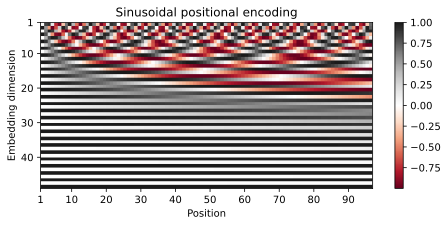

In [ ]:
encod_block = SinusoidalPosEmb(d_model=48, seq_len=96, dropout_rate=0.0)
#pe = jnp.transpose(jnp.squeeze(encod_block.pos_emb))
pe = jnp.transpose(encod_block.pos_emb)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos=ax.imshow(pe, cmap="RdGy", extent=(1, pe.shape[1]+1, pe.shape[0]+1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position")
ax.set_ylabel("Embedding dimension")
ax.set_title("Sinusoidal positional encoding")

ax.set_xticks([1]+[i*10 for i in range(1, 1+pe.shape[1] //10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])

plt.show()

#### *Toy test*

In [ ]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 512,     # - 512
    "num_hidden_layers": 6,   #N - 6
    "num_attention_heads": 8,   #h - 8
    "intermediate_size": 2048,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
}

new_config = {"src_vocab_size": 11,
    "tgt_vocab_size": 11,
    "src_seq_len": 10,
    "tgt_seq_len": 1}

gpt_config.update(new_config)

In [ ]:
def inf_test(test_model, inf_key):

    src = jnp.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype= int)
    src_mask = jnp.ones((1,10))

    memory = test_model.encode(src, src_mask, False, inf_key)

    ys = jnp.zeros((1), dtype= int)

    for i in range(9):
        out = test_model.decode(memory, src_mask, ys, causal_attention_mask(ys), False, inf_key)
        proj_out = test_model.project(out)
        prob = jax.nn.softmax(proj_out, axis=-1)
        h_prob = jnp.argmax(prob[-1])
        ys = jnp.concatenate([ys, jnp.array([h_prob])])
        rand_key

    print("Model Prediction:", ys)

    return inf_key

In [ ]:
inf_key = rand_key.copy()
for _ in range(10):
    inf_key = jr.split(inf_key)[0]
    test_model = Transformer(gpt_config, inf_key)
    #test_model = eqx.tree_inference(test_model, value=True)
    inf_key = inf_test(test_model, inf_key)

Model Prediction: [0 9 7 2 3 4 4 4 4 4]
Model Prediction: [0 3 2 3 2 3 2 3 2 3]
Model Prediction: [ 0  9  8  3 10  3 10  3 10  3]
Model Prediction: [0 7 1 0 7 1 0 7 1 0]
Model Prediction: [ 0  1  6 10  9  9  9  9  9  9]
Model Prediction: [0 0 0 0 0 0 0 0 0 0]
Model Prediction: [0 1 2 4 4 4 4 4 4 4]
Model Prediction: [0 5 5 5 5 5 5 5 5 5]
Model Prediction: [0 1 8 3 9 6 5 0 1 8]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]


In [ ]:
# with xavier initialisation #
inf_key = rand_key.copy()
for _ in range(10):
    inf_key, init_key = jr.split(inf_key)
    init_model = Transformer(gpt_config, inf_key)
    test_model = init_parameters(init_model, xavier_init, xavier_init_b, init_key)
    inf_key = inf_test(test_model, inf_key)

Model Prediction: [0 7 0 7 0 7 0 7 0 7]
Model Prediction: [0 3 3 3 3 3 3 3 3 3]
Model Prediction: [0 3 2 5 1 6 5 1 6 5]
Model Prediction: [0 5 5 5 5 5 5 5 5 5]
Model Prediction: [0 2 6 2 6 2 6 2 6 2]
Model Prediction: [0 6 9 6 9 6 9 6 9 6]
Model Prediction: [0 6 0 6 0 6 0 6 0 6]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]
Model Prediction: [0 5 8 4 4 4 4 4 4 4]
Model Prediction: [0 2 2 2 2 2 2 2 2 2]


## **Training**

###### **Test**

In [285]:
a = list(next(iter(val_dataloader)))[0]

In [432]:
jnp.sum(jnp.where(a["src_mask"], 1,0))

Array(23, dtype=int32)

In [ ]:
jnp.sum(jnp.where(a["tgt_mask"], 1,0))

In [440]:
model = Transformer(gpt_config, rand_key)

In [441]:
enc_output = model.encode(a["encoder_input"], a["src_mask"])

In [ ]:
enc_output

In [ ]:
dec_output = model.decode(a["decoder_input"], enc_output, a["src_mask"], a["tgt_mask"], True)

In [172]:
# dec_output = model.decode(a["decoder_input"], jnp.array([[True, True, True, True, False, False]]), enc_output, jnp.array([[True, True, True, True, True, False]]), True)

In [345]:
output = model.project(dec_output)

In [ ]:
output

In [ ]:
output_in_one = model(a["encoder_input"], a["decoder_input"], a["src_mask"], a["tgt_mask"], True)   # %timeit

In [ ]:
output_in_one

In [346]:
jnp.sum(output - output_in_one)

Array(0., dtype=float32)

In [442]:
inf_dec_ouput = model.decode(jnp.array([2, 4, 5, 6]), enc_output, a["src_mask"], look_ahead_mask = True)

###### Rest of code

**Random key split**

In [16]:
train_key, loader_key, split_key, r_init_key, c_init_key, val_key, acc_key = jr.split(rand_key, 7)

**Model configuration and training hyperparameters**

In [49]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 512,     # - 512
    "num_hidden_layers": 6,   #N - 6
    "num_attention_heads": 8,   #h - 8
    "intermediate_size": 2048,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
    "src_lang": "en",
    "tgt_lang": "fr",
    "epochs": 20,
    "batch_size": 32,
    "learning_rate": 1e-4,
    "ds_size": int,
}

#### Data utility functions

**Tokenizer**

In [22]:
def get_or_build_tokenizer(ds, lang):

    def get_all_sentences(ds, lang):
        for item in ds:
            yield item['translation'][lang]

    tokenizer_path = Path("tokenizer_{0}.json".format(lang))

    if not Path.exists(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token='[UNK]'))
        tokenizer.pre_tokenizer = Whitespace()
        trainer = WordLevelTrainer(special_tokens=["[UNK]","[PAD]","[SOS]","[EOS]"], min_frequency=2)
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
        tokenizer.save(str(tokenizer_path))
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path))
    return tokenizer

**Train/Test split**

In [23]:
def rand_split(ds, train_size, val_size, key):
    ds_size = ds.shape[0]
    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices
    train_ind = perm[:train_size]
    val_ind = perm[train_size:]
    train_ds = ds[train_ind]
    val_ds = ds[val_ind]
    assert (len(train_ds["id"]) + len(val_ds["id"])) - ds_size == 0

    return (train_ds, val_ds)

In [24]:
import datasets

In [25]:
def rand_split_two(ds,prop, key):
    ds_size = len(ds["id"])
    train_size = int(prop * ds_size)
    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices
    train_ind = perm[:train_size]
    val_ind = perm[train_size:]
    train_ds = datasets.Dataset.from_dict({"id":[ds["id"][i] for i in train_ind], "translation":[ds["translation"][i] for i in train_ind]})
    val_ds = datasets.Dataset.from_dict({"id":[ds["id"][i] for i in val_ind], "translation":[ds["translation"][i] for i in val_ind]})
    assert (len(train_ds["id"]) + len(val_ds["id"])) - ds_size == 0
    assert (len(train_ds["translation"]) + len(val_ds["translation"])) - ds_size == 0

    return (train_ds, val_ds)

In [26]:
def new_rand_split(ds, prop, key):
    ds_size = len(ds["encoder_input"])
    train_size = int(prop * ds_size)
    val_size = ds_size - train_size
    indices = jnp.arange(ds_size)
    perm = jr.permutation(rand_key, indices, independent=False)  # get random permutation of indices
    train_ind = perm[:train_size]
    val_ind = perm[train_size:]

    train_ds = {"encoder_input": ds["encoder_input"][train_ind], "decoder_input": ds["decoder_input"][train_ind], "encoder_mask": ds["encoder_mask"][train_ind], "decoder_mask": ds["decoder_mask"][train_ind], "label": ds["label"][train_ind]}
    val_ds ={"encoder_input": ds["encoder_input"][val_ind], "decoder_input": ds["decoder_input"][val_ind], "encoder_mask": ds["encoder_mask"][val_ind], "decoder_mask": ds["decoder_mask"][val_ind], "label": ds["label"][val_ind]}

    return (train_ds, val_ds)

**Dataset processor**

In [27]:
def process_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

    src_text = ds['translation'][src_lang]
    tgt_text = ds['translation'][tgt_lang]

    enc_input_tokens = tokenizer_src.encode(src_text).ids
    dec_input_tokens =  tokenizer_tgt.encode(tgt_text).ids

    enc_num_padding_tokens = src_seq_len - len(enc_input_tokens) - 2
    dec_num_padding_tokens = tgt_seq_len - len(dec_input_tokens) - 1

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
        raise ValueError('Sentence is too long')

    # add SOS and EOS to source text
    encoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(enc_input_tokens),
        eos_token,
        jnp.repeat(pad_token, enc_num_padding_tokens)
    ])

    # add SOS to decoder input
    decoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(dec_input_tokens, dtype=int),
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    # add EOS to expected decoder output

    label = jnp.concatenate([
        jnp.asarray(dec_input_tokens, dtype=int),
        eos_token,
        jnp.repeat(pad_token, dec_num_padding_tokens)
    ])

    assert encoder_input.shape[0] == src_seq_len
    assert decoder_input.shape[0] == tgt_seq_len
    assert label.shape[0] == tgt_seq_len

    encoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0)  # (1, seq_len)
    decoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0) & causal_attention_mask(decoder_input) # (1 seq_len) & (seq_len seq_len)

    return encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text

In [28]:
def batch_process_ds(ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int) # get sos token id from tokeniser - would be array of shape [1,]
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)


    # list comp #
    src_text = [i[src_lang] for i in ds['translation']]   # if src_lang in ds['translation'][i]
    tgt_text = [i[tgt_lang] for i in ds['translation']]

    # func #
    #get_words = lambda ds,src_lang,tgt_lang : ([i[src_lang] for i in ds['translation']], [i[tgt_lang] for i in ds['translation']])
    #src_text, tgt_text = get_words(ds, src_lang, tgt_lang)


    enc_input_tokens = [tokenizer_src.encode(i).ids for i in src_text]
    dec_input_tokens = [tokenizer_tgt.encode(i).ids for i in tgt_text]

    enc_num_padding_tokens = []
    dec_num_padding_tokens = []

    for i,j in zip(enc_input_tokens, dec_input_tokens):
        enpt = src_seq_len - len(i) - 2
        dnpt = tgt_seq_len - len(j) - 1

        if enpt < 0 or dnpt < 0:
            raise ValueError('Sentence is too long')

        enc_num_padding_tokens.append(enpt)
        dec_num_padding_tokens.append(dnpt)

    encoder_input = [jnp.concatenate([
    sos_token,
    jnp.asarray(i),
    eos_token,
    jnp.repeat(pad_token, j)
    ]) for i, j in zip(enc_input_tokens, enc_num_padding_tokens)]

    decoder_input = [jnp.concatenate([
        sos_token,
        jnp.asarray(i, dtype=int),
        jnp.repeat(pad_token, j)
    ]) for i, j in zip(dec_input_tokens, dec_num_padding_tokens)]

    label = [jnp.concatenate([
        jnp.asarray(i, dtype=int),
        eos_token,
        jnp.repeat(pad_token, j)
    ]) for i, j in zip(dec_input_tokens, dec_num_padding_tokens)]

    for i,j,k in zip(encoder_input, decoder_input, label):
        assert i.shape[0] == src_seq_len
        assert j.shape[0] == tgt_seq_len
        assert k.shape[0] == tgt_seq_len

    encoder_mask = [jnp.expand_dims((i!=pad_token), axis=0) for i in encoder_input]  # (1, seq_len)
    decoder_mask = [jnp.expand_dims((i!=pad_token), axis=0) & causal_attention_mask(j) for i,j in zip(encoder_input, decoder_input)] # (1 seq_len) & (seq_len seq_len)

    return jnp.asarray(encoder_input), jnp.asarray(decoder_input), jnp.asarray(encoder_mask), jnp.asarray(decoder_mask), jnp.asarray(label), src_text, tgt_text

**Data loader**

In [29]:
def dataloader(data, batch_size, *, key):
    dataset_size = len(data["id"])
    indices = jnp.arange(dataset_size)
    perm = jr.permutation(key, indices)  # get random permutation of indices
    (key, ) = jr.split(key, 1)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        #new_dict = {"id": [list(data["id"])[i] for i in batch_perm], "translation": [list(data["translation"])[j] for j in batch_perm]}
        new_dict = {"id": [data["id"][i] for i in batch_perm], "translation": [data["translation"][j] for j in batch_perm]}
        yield new_dict
        start = end
        end = start + batch_size

In [30]:
def new_dataloader(data, batch_size, ds_size, *, key):
    dataset_size = ds_size
    indices = jnp.arange(dataset_size)
    perm = jr.permutation(key, indices)  # get random permutation of indices
    (key, ) = jr.split(key, 1)
    start = 0
    end = batch_size
    while end < dataset_size:
        batch_perm = perm[start:end]
        yield {"encoder_inputs":data["encoder_input"][batch_perm], "encoder_masks":data["encoder_mask"][batch_perm], "decoder_inputs":data["decoder_input"][batch_perm], "decoder_masks":data["decoder_mask"][batch_perm], "labels":data["label"][batch_perm]}
        start = end
        end = start + batch_size

#### Data download and setup

In [ ]:
# def new_data(ds):
#     new_ds = {'id':[], 'en':[], 'it':[]}

#     ds_size = len(ds['translation'])
#     count=0
#     #tip = math.floor((5/100)*ds_size)
#     for i in range(50):   #ds_size

#         trans_in = ds['translation'][i]['en']
#         trans_out = ds['translation'][i]['it']
#         index = ds['id'][i]

#         new_ds['en'].append(trans_in)
#         new_ds['it'].append(trans_out)
#         new_ds['id'].append(index)

#         count+=1

#         if count % 100 == 0:
#             print(count)

#     return new_ds

In [25]:
def new_process_ds(data):
    encoder_inputs = []
    decoder_inputs = []
    encoder_masks = []
    decoder_masks = []
    labels = []


    count=0
    for i in range(gpt_config["ds_size"]):

        nd = {'id':data["id"][i], 'translation':data["translation"][i]}
        encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(
            nd, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
            )

        encoder_inputs.append(encoder_input)
        decoder_inputs.append(decoder_input)
        encoder_masks.append(encoder_mask)
        decoder_masks.append(decoder_mask)
        labels.append(label)

        count+=1

        if count % 1000 == 0:
            print(count)

    encoder_inputs = jnp.asarray(encoder_inputs)
    decoder_inputs = jnp.asarray(decoder_inputs)
    encoder_masks = jnp.asarray(encoder_masks)
    decoder_masks = jnp.asarray(decoder_masks)
    labels = jnp.asarray(labels)


    #return [encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels]
    return {"encoder_input": encoder_inputs, "decoder_input": decoder_inputs, "encoder_mask": encoder_masks, "decoder_mask": decoder_masks, "label": labels}

In [26]:
# load dataset #
ds_raw = load_dataset('opus_books', f'{gpt_config["src_lang"]}-{gpt_config["tgt_lang"]}', split='train')
ds_raw = ds_raw.with_format("jax")

# tokenize input data #
tokenizer_src = get_or_build_tokenizer(ds_raw, gpt_config["src_lang"])
tokenizer_tgt = get_or_build_tokenizer(ds_raw, gpt_config["tgt_lang"])

# # train/validation split #
# train_ds_size = int(0.9 * len(ds_raw))
# val_ds_size = len(ds_raw) - train_ds_size
# train_ds_raw, val_ds_raw = rand_split(ds_raw, train_ds_size, val_ds_size, split_key)

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-fr/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


*Check length of sentences*

In [26]:
max_len_src = 0
max_len_tgt = 0
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 471
Max length of target sentence: 482


*Check sentence length within certain number*

In [30]:
max_len_src = 0
max_len_tgt = 0
count=0
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    if len(src_ids) >50 or len(tgt_ids) > 50:
        count+=1

    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))



print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')
print(count)

Max length of source sentence: 471
Max length of target sentence: 482
15214


*New data set composed of sentences with minimum length*

In [36]:
max_len_src = 0
max_len_tgt = 0
new_ds = {"id":[], "translation":[]}
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    if len(src_ids) <=50 and len(tgt_ids) <= 50:
        new_ds["id"].append(item["id"])
        new_ds["translation"].append(item["translation"])

*Check new dataset*

In [51]:
max_len_src = 0
max_len_tgt = 0
for i in range(len(new_ds["id"])):
    src_ids = tokenizer_src.encode(new_ds['translation'][i][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(new_ds['translation'][i][gpt_config["tgt_lang"]]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 50
Max length of target sentence: 50


In [ ]:
# update gpt configuration #
new_config = {
    "src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": 55,
    "tgt_seq_len": 55,
    "ds_size": len(new_ds["id"])
    }
gpt_config.update(new_config)

In [ ]:
new_ds_raw = new_process_ds(new_ds)

In [27]:
import shutil
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [28]:
from pickle import dump, load

In [56]:
with open('./OpusEnFrproc.pkl', 'wb') as file:
    dump(new_ds_raw, file)

import shutil
shutil.copy('./OpusEnFrproc.pkl','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/OpusEnFrproc.pkl'

In [29]:
new_ds_raw = load(open('gdrive/MyDrive/Colab_Notebooks/OpusEnFrproc.pkl', 'rb'))

In [94]:
# update gpt configuration #
new_config = {
    "src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": 55,
    "tgt_seq_len": 55,
    "ds_size": len(new_ds_raw["encoder_input"])
    }
gpt_config.update(new_config)

In [30]:
# train/validation split #
train_ds_raw, val_ds_raw = new_rand_split(new_ds_raw, 0.9, split_key)

#### Training loop

**Loss functions**

*Without label smoothing*

In [32]:
# def compute_loss(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key):   # key
#     batch_size = encoder_inputs.shape[0]
#     batch_keys = jr.split(key, num=2*batch_size)
#     encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:batch_size])
#         #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])
#     decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[batch_size:2*batch_size])
#     proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)
#     logits = einops.rearrange(proj_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
#     labels = einops.rearrange(labels, " b s -> (b s)")
#     pad_pos = tokenizer_tgt.token_to_id("[PAD]")
#     pad_mask = jnp.where(labels==pad_pos, 0., 1.)
#     # label smoothing #
#     oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
#     oh_labels = oh_labels.at[:, pad_pos].set(0.)
#     # s_labels = optax.smooth_labels(oh_labels, alpha=0.1)
#     # s_labels = s_labels.at[:, pad_pos].set(0.)

#     logits=logits.at[:, pad_pos].set(-1e3)

#     loss = optax.softmax_cross_entropy(logits=logits, labels=oh_labels)
#     loss_masked = loss * pad_mask

#     return jnp.sum(loss_masked)/jnp.sum(pad_mask)   # loss_masked

*With label smoothing*

In [31]:
# ds = jnp.stack([jnp.concatenate([jnp.array([75, 4, 56, 32, 51, 49, 78, 23], dtype=int), jnp.ones(shape=(47,), dtype=int)]), jnp.concatenate([jnp.array([31, 84, 33, 23, 4, 97, 65], dtype=int), jnp.ones(shape=(48,), dtype=int)])])

In [72]:
# gpt_config = {
#     "src_vocab_size": 22000,
#     "tgt_vocab_size": 30000,
#     "src_seq_len": 55,
#     "tgt_seq_len": 55,
#     "d_model": 64,     # - 512
#     "num_hidden_layers": 2,   #N - 6
#     "num_attention_heads": 2,   #h - 8
#     "intermediate_size": 128,    #d_ff - 2048
#     "hidden_dropout_prob": 0.1,
#     "attention_dropout_prob": 0.1,
#     "src_lang": "en",
#     "tgt_lang": "fr",
#     "epochs": 20,
#     "batch_size": 2,
#     "learning_rate": 1e-4,
#     "ds_size": 20,
# }

In [73]:
# model = Transformer(gpt_config, rand_key)

In [81]:
# compute_loss(model, new_ds_raw["encoder_input"][0:2], new_ds_raw["encoder_mask"][0:2], new_ds_raw["decoder_input"][0:2], new_ds_raw["decoder_mask"][0:2], new_ds_raw["label"][0:2], rand_key)

Array(20.431934, dtype=float32)

In [80]:
def compute_loss(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key):   # key
    batch_size = encoder_inputs.shape[0]
    batch_keys = jr.split(key, num=2*batch_size)
    encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:batch_size])
        #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])
    decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[batch_size:2*batch_size])
    proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)

    output = einops.rearrange(proj_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")

    pad_pos = tokenizer_tgt.token_to_id("[PAD]")

    oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
    oh_labels = oh_labels.at[:, pad_pos].set(0.)  # unnecessary step but useful if I want to get rid of "label smoothing"

    s_labels = optax.smooth_labels(oh_labels, alpha=0.1)  # label smoothing

    s_labels = s_labels.at[:, pad_pos].set(0.)   # set all "vertical" padding tokens to one i.e. all possible alternatives to 0 (this wouldn't be necessary with no label smoothing - redundacy yet)
    mask = jnp.asarray(labels == pad_pos) # T/F - true/false mask
    new_labels = jax.vmap(jnp.where, in_axes=(0,None, 0))(mask, 0., s_labels)  # so padding token is zero vertically but also entire rows of the paddding tokens are zero (think cross in a way)
    pad_mask = jnp.where(labels==pad_pos, 0., 1.)  # 1/0  - useful for working out number of non-padding tokens

    output=output.at[:, pad_pos].set(-1e4)  #or -jnp.inf - for model output, ensure for every prediction that the padding token is set as negative possible for getting zero probability in the softmax

    loss = optax.softmax_cross_entropy(logits=output, labels=new_labels)  #compute cross entropy loss

    return jnp.sum(loss)/jnp.sum(pad_mask)  # calculate mean of non padding tokens only!

*Make update step*

In [82]:
@eqx.filter_jit
def make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt_update, key):  # key
    key, new_key = jr.split(key)
    loss_fn = eqx.filter_value_and_grad(compute_loss)
    loss, grads = loss_fn(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key) # key
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state, new_key

**Model initialisation** - *Including custom Xavier uniform initialisation*

In [83]:
# weight initialiser #
def xavier_init(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, param.shape)
    return params

# bias initialiser #
def xavier_init_b(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, (1, param.shape[0]))
    params = jnp.squeeze(params, axis=0)
    return params

# initiliase custom model parameters #
def init_parameters(model, init_fn, init_fn_b, key):

    wkey, bkey, ekey = jr.split(key, 3)

    is_linear = lambda x: isinstance(x, eqx.nn.Linear)

    get_weights = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey) for weight, subkey in zip(weights, jr.split(wkey, len(weights)))]
    model_w = eqx.tree_at(get_weights, model, new_weights)

    get_biases = lambda m: [x.bias for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    biases = get_biases(model_w)
    new_biases = [init_fn_b(bias, subkey) for bias, subkey in zip(biases, jr.split(bkey, len(biases)))]
    model_wb = eqx.tree_at(get_biases, model_w, new_biases)

    is_embedding = lambda x: isinstance(x, eqx.nn.Embedding)

    get_embs = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_embedding) if is_embedding(x)]
    embs = get_embs(model_wb)
    new_embs = [init_fn(embedding, subkey) for embedding, subkey in zip(embs, jr.split(ekey, len(embs)))]
    new_model = eqx.tree_at(get_embs, model_wb, new_embs)

    return new_model

In [95]:
# custom model initialisation #
init_model = Transformer(gpt_config, r_init_key)
model = init_parameters(init_model, xavier_init, xavier_init_b, c_init_key)

**Optimiser initialisation**  - *including clipping grad norm and learning rate schedule*

In [96]:
# setup optax #
opt = optax.inject_hyperparams(optax.adam)(learning_rate = optax.warmup_cosine_decay_schedule(
    init_value=1e-9,
    peak_value=1e-3,
    warmup_steps = math.floor((gpt_config["ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.075),
    decay_steps = math.floor((gpt_config["ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.925),
    end_value = 2e-4 * 1e-3)  # min value (alpha) for cosine schedule is alpha = end_value / peak_value, so I want alpha to be 2e-4
)

#opt = optax.adam(learning_rate=gpt_config["learning_rate"])

opt = optax.chain(optax.clip_by_global_norm(1.0), opt)

opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

**Validation accuracy**

In [90]:
def new_run_validation(
    model,
    validation_ds,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    num_examples,
    val_key
):

    inference_model = eqx.tree_inference(model, value=True)

    # match with training loop and process ds
    val_ds = next(new_dataloader(validation_ds, batch_size=num_examples, ds_size=len(validation_ds["encoder_input"]), key=val_key))


    model_out = [greedy_decode(model, i, j, tokenizer_src, tokenizer_tgt, max_len) for i,j in zip(val_ds["encoder_inputs"], val_ds["encoder_masks"])]

    model_out_text = [tokenizer_tgt.decode(mo) for mo in model_out]

    targets = [tokenizer_tgt.decode(val_ds["decoder_inputs"][i]) for i in range(num_examples)]

    metric1 = WordErrorRate()
    lossWER = metric1(model_out_text, targets)

    metric2 = CharErrorRate()
    lossCER = metric2(model_out_text, targets)

    metric3 = BLEUScore()
    lossBS = metric3(model_out_text, targets)

    return lossWER, lossCER, lossBS


In [48]:
# a,b,c = new_run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, 5, 2, rand_key)

**Training loop**

In [ ]:
train_loss = {}   # for graphing training loss
val_loss = {}
epochs = gpt_config["epochs"]
ocr = 0.1   # % of steps that we want to validate the model
num_steps = (gpt_config["ds_size"]//gpt_config["batch_size"]) * ocr
curr_state = 0
for epoch in range(epochs):
    with tqdm.tqdm(
        new_dataloader(train_ds_raw, gpt_config["batch_size"], gpt_config["ds_size"], key=loader_key),
        total = gpt_config["ds_size"]//gpt_config["batch_size"],
        unit = "steps",
        desc = f"Epoch {epoch+1}/{epochs}",
    ) as tqdm_epoch:
        for data in tqdm_epoch:

            tr_loss, model, opt_state, train_key = make_step(model, data["encoder_inputs"], data["encoder_masks"], data["decoder_inputs"], data["decoder_masks"], data["labels"], opt_state, opt.update, train_key)

            if curr_state % num_steps == 0:
                w_l, c_l, BS_l = new_run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, max_len=51, num_examples=gpt_config["batch_size"], val_key=acc_key)
                (acc_key, ) = jr.split(acc_key, 1)


            tqdm_epoch.set_postfix(loss = tr_loss, wordloss=w_l, characterloss=c_l, BLEUScore=BS_l)
            curr_state += 1

    loader_key = jr.split(loader_key, 1)[0]
    train_loss[epoch]=tr_loss
    val_loss[epoch]=w_l

*Time-saving loop attempt*

In [ ]:
# train_loss = {}   # for graphing training loss
# epochs = gpt_config["epochs"]
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         new_dataloader(train_ds_raw, gpt_config["batch_size"], gpt_config["ds_size"], key=loader_key),
#         total = gpt_config["ds_size"]//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:

#             tr_loss, model, opt_state, train_key = make_step(model, data["encoder_inputs"], data["encoder_masks"], data["decoder_inputs"], data["decoder_masks"], data["labels"], opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)
#     loader_key = jr.split(loader_key, 1)[0]
#     train_loss[epoch]=tr_loss

*Normal loop*

In [ ]:
# train_loss = {}   # for graphing training loss
# epochs = gpt_config["epochs"]
# for epoch in range(gpt_config["epochs"]):
#     with tqdm.tqdm(
#         dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
#         total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:
#             encoder_inputs = []
#             decoder_inputs = []
#             encoder_masks = []
#             decoder_masks = []
#             labels = []
#             for i in range(gpt_config["batch_size"]):
#                 id = data["id"][i]
#                 trans = data["translation"][i]
#                 new_dict = {"id":id, "translation":trans}
#                 encoder_input, decoder_input, encoder_mask, decoder_mask, label, src_text, tgt_text = process_ds(
#                     new_dict, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#                     )

#                 encoder_inputs.append(encoder_input)
#                 decoder_inputs.append(decoder_input)
#                 encoder_masks.append(encoder_mask)
#                 decoder_masks.append(decoder_mask)
#                 labels.append(label)

#             encoder_inputs = jnp.asarray(encoder_inputs)
#             decoder_inputs = jnp.asarray(decoder_inputs)
#             encoder_masks = jnp.asarray(encoder_masks)
#             decoder_masks = jnp.asarray(decoder_masks)
#             labels = jnp.asarray(labels)

#             tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)
#     loader_key = jr.split(loader_key, 1)[0]
#     train_loss[epoch]=tr_loss

*Batched loop*

In [ ]:
# train_loss = {}   # for graphing training loss
# epochs = gpt_config["epochs"]
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
#         total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:
#             encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
#                 data, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#                 )

#             tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)
#     loader_key = jr.split(loader_key, 1)[0]
#     train_loss[epoch]=tr_loss

*With validation*

In [ ]:
# train_loss = {}   # for graphing training loss
# #val_loss = {}
# epochs = gpt_config["epochs"]
# for epoch in range(epochs):
#     with tqdm.tqdm(
#         dataloader(train_ds_raw, gpt_config["batch_size"], key=loader_key),
#         total = len(train_ds_raw["translation"])//gpt_config["batch_size"],
#         unit = "steps",
#         desc = f"Epoch {epoch+1}/{epochs}",
#     ) as tqdm_epoch:
#         for data in tqdm_epoch:
#             encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
#                 data, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#                 )

#             tr_loss, model, opt_state, train_key = make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt.update, train_key)

#             tqdm_epoch.set_postfix(loss = tr_loss)

#     run_validation(model, val_ds_raw, tokenizer_src, tokenizer_tgt, 10, 2, val_key)
#     loader_key = jr.split(loader_key, 1)[0]
#     val_key = jr.split(val_key, 1)[0]
#     train_loss[epoch]=tr_loss

**Save and load model**

In [52]:
eqx.tree_serialise_leaves("EnFrVanilla.eqx", model)
shutil.copy('/content/EnFrVanilla.eqx','/content/gdrive/MyDrive/Colab_Notebooks')

'/content/gdrive/MyDrive/Colab_Notebooks/EnFrVanilla.eqx'

In [34]:
model = Transformer(gpt_config, r_init_key)
loaded_model = eqx.tree_deserialise_leaves('/content/gdrive/MyDrive/Colab_Notebooks/EnFrVanilla.eqx', model)

**Plot loss curve**

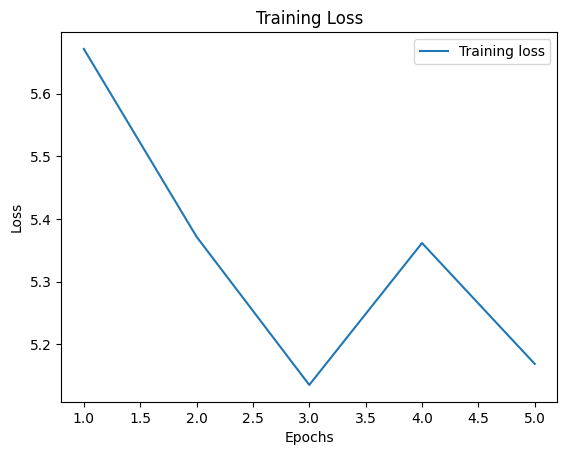

In [ ]:
epcs = jnp.arange(1, epochs+1, step=1)
plt.plot(epcs, train_loss.values(), label='Training loss')
plt.plot(epcs, val_loss.values(), label='Validation loss')

plt.title('Training Loss and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(jnp.arange(0, epochs+1, steps=2))

plt.legend(loc='best')
plt.show()

## **Inference**

In [98]:
def greedy_decode(
    model,
    source,
    source_mask,
    tokenizer_src,
    tokenizer_tgt,
    max_len
):
    sos_idx = jnp.asarray(tokenizer_tgt.token_to_id("[SOS]"))
    eos_idx = jnp.asarray(tokenizer_tgt.token_to_id("[EOS]"))

    # This computation now gets used repeatedly
    encoder_output = model.encode(source, source_mask)

    decoder_input = jnp.asarray([sos_idx])    # SOS token to start decoding

    while True:
        if decoder_input.shape[0] == max_len:
            break
        else:
            decoder_mask = causal_attention_mask(decoder_input)
            out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)
            prob = jax.nn.softmax(model.project(out), axis=-1)
            next_word = jnp.asarray([jnp.argmax(prob[-1])])
            decoder_input = jnp.concatenate([decoder_input, next_word])
            if next_word == eos_idx:
                break

    return decoder_input

In [36]:
def run_validation(
    model,
    validation_ds,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    num_examples,
    val_key
):

    inference_model = eqx.tree_inference(model, value=True)



    # match with training loop and process ds
    val_ds = next(new_dataloader(validation_ds, batch_size=num_examples, ds_size=len(validation_ds["encoder_input"]), key=val_key))


    model_out = [greedy_decode(model, i, j, tokenizer_src, tokenizer_tgt, max_len) for i,j in zip(val_ds["encoder_inputs"], val_ds["encoder_masks"])]

    model_out_text = [tokenizer_tgt.decode(mo) for mo in model_out]

    for i in range(num_examples):

        print(f'SOURCE: {tokenizer_src.decode(val_ds["encoder_inputs"][i])}')
        print(f'TARGET: {tokenizer_tgt.decode(val_ds["decoder_inputs"][i])}')
        print(f'PREDICTED: {model_out_text[i]}')


In [ ]:
# def run_validation(
#     model,
#     validation_ds,
#     tokenizer_src,
#     tokenizer_tgt,
#     max_len,
#     num_examples,
#     val_key
# ):

#     inference_model = eqx.tree_inference(model, value=True)



#     # match with training loop and process ds
#     val_ds = next(dataloader(validation_ds, batch_size=num_examples, key=val_key))

#     encoder_inputs, decoder_inputs, encoder_masks, decoder_masks, labels, src_text, tgt_text = batch_process_ds(
#             val_ds, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"]
#             )

#     model_out = [greedy_decode(model, i, j, tokenizer_src, tokenizer_tgt, max_len) for i,j in zip(encoder_inputs, encoder_masks)]

#     model_out_text = [tokenizer_tgt.decode(mo) for mo in model_out]

#     for i in range(num_examples):

#         print(f'SOURCE: {src_text[i]}')
#         print(f'TARGET: {tgt_text[i]}')
#         print(f'PREDICTED: {model_out_text[i]}')


In [39]:
val_key = jr.split(val_key, 1)[0]
run_validation(loaded_model, val_ds_raw, tokenizer_src, tokenizer_tgt, 50, 3, val_key)

SOURCE: He appealed to his son .
TARGET: Il se tourna vers son fils .
PREDICTED: Il demandait à son fils :
SOURCE: " _You_ are dancing with the only handsome girl in the room ," said Mr . Darcy , looking at the eldest Miss Bennet .
TARGET: – Votre danseuse est la seule jolie personne de la réunion , dit Mr . Darcy en désignant du regard l ’ aînée des demoiselles Bennet .
PREDICTED: – Vous avec la plus belle enfant , dit Mr . Darcy en regardant le portrait aînée .
SOURCE: Mousqueton ’ s horse rejoined them , and galloped by the side of his companions .
TARGET: Celui de Mousqueton les avait rejoints , et galopait tout seul à son rang .
PREDICTED: Mousqueton est le cheval de Mousqueton , il le cocher en compagnie , et , au côté de ses compagnons .


In [40]:
a = 'Hi I am happy'

In [43]:
b = tokenizer_src.encode(a).ids

**Custom Translation**

In [56]:
def translate(string: str):

    #string = str(string)

    inference_model = eqx.tree_inference(loaded_model, value=True)

    sos_token = jnp.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int)
    eos_token = jnp.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
    pad_token  = jnp.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

    enc_input_tokens = tokenizer_src.encode(string).ids

    enc_num_padding_tokens = gpt_config["src_seq_len"] - len(enc_input_tokens) - 2

    if enc_num_padding_tokens < 0:
        raise ValueError('Sentence is too long')


    encoder_input = jnp.concatenate([
        sos_token,
        jnp.asarray(enc_input_tokens),
        eos_token,
        jnp.repeat(pad_token, enc_num_padding_tokens)
    ])

    assert encoder_input.shape[0] == gpt_config["src_seq_len"]
    encoder_mask = jnp.expand_dims((encoder_input!= pad_token), axis=0)

    encoder_input = jnp.asarray(encoder_input)
    encoder_mask = jnp.asarray(encoder_mask)
    model_output = greedy_decode(inference_model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len=50)

    print(f'PREDICTED: {tokenizer_tgt.decode(model_output)}')

In [58]:
translate('I will go home tomorrow, but I think I will arrive late.')

PREDICTED: Je rentre chez lui , mais je crois que je arrivera tard .


## Pytorch data loader

In [31]:
train_key, loader_key, split_key, r_init_key, c_init_key, val_key = jr.split(rand_key, 6)

*Transformer configuration*

In [54]:
gpt_config = {
    "src_vocab_size": int,
    "tgt_vocab_size": int,
    "src_seq_len": int,
    "tgt_seq_len": int,
    "d_model": 64,     # - 512
    "num_hidden_layers": 2,   #N - 6
    "num_attention_heads": 2,   #h - 8
    "intermediate_size": 128,    #d_ff - 2048
    "hidden_dropout_prob": 0.1,
    "attention_dropout_prob": 0.1,
    "src_lang": "en",
    "tgt_lang": "fr",
    "epochs": 2,
    "batch_size": 4,
    "learning_rate": 1e-4,
    "train_ds_size": int,
    "ds_max_len": 55,
    "val_batch_size":1,
}

*Load Dataset and initialise tokeniser*

In [33]:
# load dataset #
ds_raw = load_dataset('opus_books', f'{gpt_config["src_lang"]}-{gpt_config["tgt_lang"]}', split='train')
#ds_raw = ds_raw.with_format("jax")

# tokenize input data #
tokenizer_src = get_or_build_tokenizer(ds_raw, gpt_config["src_lang"])
tokenizer_tgt = get_or_build_tokenizer(ds_raw, gpt_config["tgt_lang"])

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [151]:
# # train/validation split #
# train_ds_size = int(0.9 * len(short_ds_raw))   # 90% split of dataset
# val_ds_size = len(short_ds_raw) - train_ds_size
# train_ds_raw, val_ds_raw = rand_split(short_ds_raw, train_ds_size, val_ds_size, split_key)

*Check length of sentences*

In [30]:
max_len_src = 0
max_len_tgt = 0
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 471
Max length of target sentence: 482


###### Shorten dataset - **optional but recommended for speed**

*Check sentence length within certain number*

In [31]:
count=0
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    if len(src_ids) > gpt_config["ds_max_len"] or len(tgt_ids) > gpt_config["ds_max_len"]:
        count+=1
print(f'Number of sentences longer than {gpt_config["ds_max_len"]} tokens: {count}')

Number of sentences longer than 55 tokens: 11785


*New data set composed of sentences with minimum length*

In [34]:
# shorten training dataset #
short_ds_raw = {"id":[], "translation":[]}
for item in ds_raw:
    src_ids = tokenizer_src.encode(item['translation'][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(item['translation'][gpt_config["tgt_lang"]]).ids
    if len(src_ids) <= gpt_config["ds_max_len"] and len(tgt_ids) <= gpt_config["ds_max_len"]:
        short_ds_raw["id"].append(item["id"])
        short_ds_raw["translation"].append(item["translation"])

*Check new dataset*

In [33]:
max_len_src = 0
max_len_tgt = 0
for i in range(len(short_ds_raw["id"])):
    src_ids = tokenizer_src.encode(short_ds_raw['translation'][i][gpt_config["src_lang"]]).ids
    tgt_ids = tokenizer_tgt.encode(short_ds_raw['translation'][i][gpt_config["tgt_lang"]]).ids
    max_len_src = max(max_len_src, len(src_ids))
    max_len_tgt = max(max_len_tgt, len(tgt_ids))

print(f'Max length of source sentence: {max_len_src}')
print(f'Max length of target sentence: {max_len_tgt}')

Max length of source sentence: 55
Max length of target sentence: 55


*Train/validation split*

In [36]:
# train/validation split #
train_ds_raw, val_ds_raw = rand_split_two(short_ds_raw, 0.9, split_key)   # 90% split of dataset

In [179]:
# type(ds_raw)
# type(train_ds_raw)

datasets.arrow_dataset.Dataset

*Update configuration*

In [55]:
# update gpt configuration #
new_config = {
    "src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": gpt_config["ds_max_len"]+5,
    "tgt_seq_len": gpt_config["ds_max_len"]+5,
    "train_ds_size": len(train_ds_raw["id"])
    }
gpt_config.update(new_config)

###### "Non-shortened" dataset - need to look at!

In [ ]:
# create two batch subsets #
# needs to be iterator i.e. a function with yield... & split key also

In [ ]:
# update gpt configuration #
new_config = {
    "src_vocab_size": tokenizer_src.get_vocab_size(),
    "tgt_vocab_size": tokenizer_tgt.get_vocab_size(),
    "src_seq_len": 55,
    "tgt_seq_len": 55,
    "ds_size": len(new_ds["id"])
    }
gpt_config.update(new_config)

###### DataLoader

In [61]:
# import numpy as np
# from torch.utils import data

In [37]:
class TranslationDataset(data.Dataset):

      def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, src_seq_len, tgt_seq_len):
          super().__init__()


          self.src_seq_len = src_seq_len
          self.tgt_seq_len = tgt_seq_len

          self.ds = ds
          self.tokenizer_src = tokenizer_src
          self.tokenizer_tgt = tokenizer_tgt
          self.src_lang = src_lang
          self.tgt_lang = tgt_lang

          self.sos_token = np.asarray([tokenizer_src.token_to_id("[SOS]")], dtype=int)
          self.eos_token = np.asarray([tokenizer_src.token_to_id("[EOS]")], dtype=int)
          self.pad_token  = np.asarray([tokenizer_src.token_to_id("[PAD]")], dtype=int)

      def __len__(self):
          return len(self.ds)

      def __getitem__(self, idx):
          src_target_pair = self.ds[idx]

          src_text = src_target_pair['translation'][self.src_lang]
          tgt_text = src_target_pair['translation'][self.tgt_lang]

          enc_input_tokens = self.tokenizer_src.encode(src_text).ids
          dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids


          enc_num_padding_tokens = self.src_seq_len - len(enc_input_tokens) - 2
          dec_num_padding_tokens = self.tgt_seq_len - len(dec_input_tokens) - 2   # should be -1 if not including EOS token
          lab_num_padding_tokens = dec_num_padding_tokens + 1   # not necessary if omitting EOS token in decoder input


          if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
              raise ValueError('Sentence is too long')

          # add SOS and EOS to source text
          encoder_input = np.concatenate([
              self.sos_token,
              np.asarray(enc_input_tokens),
              self.eos_token,
              np.repeat(self.pad_token, enc_num_padding_tokens)
          ])


          # add SOS to decoder input - I have also added EOS token - logically makes sense as we want the decoder to predict EOS at inference time! but I have seen implementations that specifically do not include EOS in decoder training input
          decoder_input = np.concatenate([
              self.sos_token,
              np.asarray(dec_input_tokens, dtype=int),
              self.eos_token,
              np.repeat(self.pad_token, dec_num_padding_tokens)
          ])

          # add EOS to expected decoder output
          label = np.concatenate([
              np.asarray(dec_input_tokens, dtype=int),
              self.eos_token,
              np.repeat(self.pad_token, lab_num_padding_tokens) # not dec_num
          ])

          assert encoder_input.shape[0] == self.src_seq_len
          assert decoder_input.shape[0] == self.tgt_seq_len
          assert label.shape[0] == self.tgt_seq_len


          src_mask = np.expand_dims((encoder_input!= self.pad_token), axis=0)  # (1, seq_len)
          tgt_mask = np.expand_dims((decoder_input!= self.pad_token), axis=0) # & np.asarray(causal_attention_mask(decoder_input)) # (1 seq_len) & (seq_len seq_len)

          return {
              "encoder_input": encoder_input,
              "decoder_input": decoder_input,
              "src_mask": src_mask,
              "tgt_mask": tgt_mask,
              "label": label,
              "src_text": src_text,
              "tgt_text": tgt_text,
          }


In [111]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    print("hi")
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

In [ ]:
# test_ds = TranslationDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, "en", "fr", 500)
# test_dataloader = NumpyLoader(test_ds, batch_size=2, shuffle=True)

# # for batch in test_dataloader:
# #     print(batch)
# #     assert 1+1==3

# a = iter(test_dataloader)
# next(a)

In [207]:
train_ds = TranslationDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"])
val_ds = TranslationDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, gpt_config["src_lang"], gpt_config["tgt_lang"], gpt_config["src_seq_len"], gpt_config["tgt_seq_len"])

# train_dataloader = NumpyLoader(train_ds, batch_size=gpt_config["batch_size"], shuffle=True, drop_last=True)
# val_dataloader = NumpyLoader(val_ds, batch_size=gpt_config["val_batch_size"], shuffle=True, drop_last=True)

train_dataloader = data.DataLoader(train_ds, batch_size=gpt_config["batch_size"], shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_ds, batch_size=gpt_config["val_batch_size"], shuffle=True, drop_last=True)

Validation

In [101]:
# def validation(
#     model,
#     batch,
#     tokenizer_src,
#     tokenizer_tgt,
#     max_len: int = gpt_config["tgt_seq_len"],
#     print: bool = False,
#     metric: bool = False
# ):

#     inf_model = eqx.tree_inference(model, value=True)

#     g_dec = functools.partial(greedy_decode, inf_model, tokenizer_src, tokenizer_tgt, max_len)
#     model_out = []
#     for item in batch:
#         output = g_dec(item["encoder_input"], item["encoder_mask"])
#         model_out.append(output)

#     #model_out = [greedy_decode(inf_model, i, j, tokenizer_src, tokenizer_tgt, max_len) for i,j in zip(batch["encoder_input"], batch["encoder_mask"])]

#     #predicted_texts = [tokenizer_tgt.decode(i) for i in model_out]

#     predicted_texts=[]
#     for i in model_out:
#         predicted_texts.append(tokenizer_tgt.decode(i))

#     source_texts = [i for i in batch["src_text"]]   # [0]
#     expected_texts = [i for i in batch["tgt_text"]]   # [0]

#     if print == True:
#         for  i in range(batch.shape[0]):
#             print(f'SOURCE: {source_texts[i]}')
#             print(f'TARGET: {expected_texts[i]}')
#             print(f'PREDICTED: {predicted_texts[i]}')

#     if metric == True:
#         metric1 = WordErrorRate()
#         lossWER = metric1(predicted_texts, expected_texts)

#         metric2 = CharErrorRate()
#         lossCER = metric2(predicted_texts, expected_texts)

#         metric3 = BLEUScore()
#         lossBS = metric3(predicted_texts, expected_texts)

#         return lossWER, lossCER, lossBS

In [103]:
# validation(model, a, tokenizer_src, tokenizer_tgt, max_len=60, print=False, metric=False)

In [40]:
def greedy_decode(
    model,
    tokenizer_src,
    tokenizer_tgt,
    max_len,
    src,
    src_mask
):
    @eqx.filter_jit
    def decode_pass(model, encoder_output,src_mask, decoder_input):
        out = model.decode(decoder_input, encoder_output, src_mask, look_ahead_mask=True)
        prob = jax.nn.softmax(model.project(out), axis=-1)
        next_word = jnp.argmax(prob[-1])
        return next_word

    sos_idx = tokenizer_tgt.token_to_id("[SOS]")
    eos_idx = tokenizer_tgt.token_to_id("[EOS]")
    encoder_output = model.encode(src, src_mask)   # This computation now gets used repeatedly
    dec_pass = functools.partial(decode_pass, model, encoder_output, src_mask)
    decoder_input = jnp.asarray([sos_idx])    # SOS token to start decoding
    for i in range(max_len):
        dec_shape = decoder_input.shape[-1]
        next_word = dec_pass(decoder_input)
        if next_word == eos_idx:
            break
        decoder_input = jnp.concatenate([decoder_input, jnp.asarray([next_word])])

    return decoder_input

In [123]:
model = Transformer(gpt_config, r_init_key)

In [124]:
a = next(iter(val_dataloader))

In [ ]:
# greedy_decode(model, tokenizer_src, tokenizer_tgt, 55, a["encoder_input"], a["src_mask"])

In [200]:
def accuracy(model, input, tokenizer_tgt, max_len):
    inf_model = eqx.tree_inference(model, value=True)
    encoder_input = jnp.squeeze(jnp.asarray(input["encoder_input"], dtype=int), axis = 0)
    src_mask = jnp.squeeze(jnp.asarray(input["src_mask"]), axis = 0)

    model_output = greedy_decode(inf_model, tokenizer_src, tokenizer_tgt, max_len, encoder_input, src_mask)

    predicted = str(tokenizer_tgt.decode(model_output))
    expected = input["tgt_text"][0]

    #print(predicted, expected)
    metric1 = WordErrorRate()
    lossWER = metric1(predicted, expected)

    metric2 = CharErrorRate()
    lossCER = metric2(predicted, expected)

    metric3 = BLEUScore()
    lossBS = metric3(predicted, expected)

    return float(lossWER), float(lossCER), float(lossBS)

In [201]:
# accuracy(model, a, tokenizer_tgt, 55)

In [ ]:
# two masks:
  # for padding mask we need to have this mini square inside I think - look to BERT implementation for how they did it!
  #mask = jnp.multiply(jnp.expand_dims(mask, axis=-1), jnp.expand_dims(mask, axis=-2))
  # for the padding mask, need to think about encoder vs decoder mask also (they are not going to be the same!! if french is longer than english sentence for e.g.), and also training vs. inference, look at functions to see how they are generated

  #so causal mask has to look like padding mask, but with triangular matrix inside!

*Loss function - with label smoothing*

In [210]:
def compute_loss(model, encoder_inputs, src_masks, decoder_inputs, tgt_masks, labels, key):   # key
    batch_size = gpt_config["batch_size"]    # encoder_inputs.shape[0]
    batch_keys = jr.split(key, num=batch_size)


    # encoder_output = jax.vmap(model.encode, in_axes=(0, 0, None, 0))(encoder_inputs, encoder_masks, True, batch_keys[0:batch_size])
    #     #encoder_output = jax.vmap(functools.partial(model.encode, enable_dropout=True), in_axes=(0, 0, 0))(encoder_inputs, encoder_masks, batch_keys[0:8])
    # decoder_output = jax.vmap(model.decode, in_axes=(0, 0, 0, 0, None, 0))(encoder_output, encoder_masks, decoder_inputs, decoder_masks, True, batch_keys[batch_size:2*batch_size])
    # proj_output = jax.vmap(model.project, in_axes=0)(decoder_output)


    model_output = jax.vmap(model, in_axes=(0, 0, 0, 0, None, None, 0))(encoder_inputs, decoder_inputs, src_masks, tgt_masks, True, True, batch_keys)

    output = einops.rearrange(model_output, "b s v -> (b s) v") # , b=batch_size, s = proj_output[1], tokenizer_tgt.get_vocab_size())
    labels = einops.rearrange(labels, " b s -> (b s)")

    pad_pos = tokenizer_tgt.token_to_id("[PAD]")

    oh_labels = jax.nn.one_hot(labels, tokenizer_tgt.get_vocab_size())
    oh_labels = oh_labels.at[:, pad_pos].set(0.)  # unnecessary step but useful if I want to get rid of "label smoothing"

    s_labels = optax.smooth_labels(oh_labels, alpha=0.1)  # label smoothing

    s_labels = s_labels.at[:, pad_pos].set(0.)   # set all "vertical" padding tokens to one i.e. all possible alternatives to 0 (this wouldn't be necessary with no label smoothing - redundacy yet)
    mask = jnp.asarray(labels == pad_pos) # T/F - true/false mask
    new_labels = jax.vmap(jnp.where, in_axes=(0,None, 0))(mask, 0., s_labels)  # so padding token is zero vertically but also entire rows of the paddding tokens are zero (think cross in a way)
    pad_mask = jnp.where(labels==pad_pos, 0., 1.)  # 1/0  - useful for working out number of non-padding tokens

    output=output.at[:, pad_pos].set(-1e4)  #or -jnp.inf - for model output, ensure for every prediction that the padding token is set as negative possible for getting zero probability in the softmax

    loss = optax.softmax_cross_entropy(logits=output, labels=new_labels)  #compute cross entropy loss

    return jnp.sum(loss)/jnp.sum(pad_mask)  # calculate mean of non padding tokens only!

*Make update step*

In [43]:
@eqx.filter_jit
def make_step(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, opt_state, opt_update, key):  # key
    key, new_key = jr.split(key)
    loss_fn = eqx.filter_value_and_grad(compute_loss)
    loss, grads = loss_fn(model, encoder_inputs, encoder_masks, decoder_inputs, decoder_masks, labels, key) # key
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)

    return loss, model, opt_state, new_key

**Model initialisation** - *Including custom Xavier uniform initialisation*

In [44]:
# weight initialiser #
def xavier_init(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, param.shape)
    return params

# bias initialiser #
def xavier_init_b(param: jax.Array, key = jr.PRNGKey) -> jax.Array:
    initialiser = jax.nn.initializers.glorot_uniform()
    params = initialiser(key, (1, param.shape[0]))
    params = jnp.squeeze(params, axis=0)
    return params

# initiliase custom model parameters #
def init_parameters(model, init_fn, init_fn_b, key):

    wkey, bkey, ekey = jr.split(key, 3)

    is_linear = lambda x: isinstance(x, eqx.nn.Linear)

    get_weights = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    weights = get_weights(model)
    new_weights = [init_fn(weight, subkey) for weight, subkey in zip(weights, jr.split(wkey, len(weights)))]
    model_w = eqx.tree_at(get_weights, model, new_weights)

    get_biases = lambda m: [x.bias for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear) if is_linear(x)]
    biases = get_biases(model_w)
    new_biases = [init_fn_b(bias, subkey) for bias, subkey in zip(biases, jr.split(bkey, len(biases)))]
    model_wb = eqx.tree_at(get_biases, model_w, new_biases)

    is_embedding = lambda x: isinstance(x, eqx.nn.Embedding)

    get_embs = lambda m: [x.weight for x in jax.tree_util.tree_leaves(m, is_leaf=is_embedding) if is_embedding(x)]
    embs = get_embs(model_wb)
    new_embs = [init_fn(embedding, subkey) for embedding, subkey in zip(embs, jr.split(ekey, len(embs)))]
    new_model = eqx.tree_at(get_embs, model_wb, new_embs)

    return new_model

In [205]:
# custom model initialisation #
init_model = Transformer(gpt_config, r_init_key)
model = init_parameters(init_model, xavier_init, xavier_init_b, c_init_key)

**Optimiser initialisation**  - *including clipping grad norm and learning rate schedule*

In [206]:
# setup optax #
opt = optax.inject_hyperparams(optax.adam)(learning_rate = optax.warmup_cosine_decay_schedule(
    init_value=1e-9,
    peak_value=1e-3,
    warmup_steps = math.floor((gpt_config["train_ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.075),
    decay_steps = math.floor((gpt_config["train_ds_size"]//gpt_config["batch_size"]) * gpt_config["epochs"] * 0.925),
    end_value = 2e-4)  # min value (alpha) for cosine schedule is alpha = end_value / peak_value - lr will stay constant after reaching this scalar value
)

#opt = optax.adam(learning_rate=gpt_config["learning_rate"])

opt = optax.chain(optax.clip_by_global_norm(1.0), opt)

opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [204]:
# for g in iter(train_dataloader):
#     encoder_input = jnp.asarray(g["encoder_input"])
#     src_mask = jnp.asarray(g["src_mask"])
#     print(encoder_input.shape, src_mask.shape)
#     assert 2+2==5

In [120]:
# for g in iter(train_dataloader):
#     encoder_input = [g[i]["encoder_input"] for i in range(gpt_config["batch_size"])]
#     print(encoder_input)
#     assert 2+2==5

In [ ]:
train_loss = {}   # for graphing training loss and validation loss
val_loss = {}
epochs = gpt_config["epochs"]
ocr = 0.2   # % of steps that we want to validate the model
num_steps = math.floor(gpt_config["train_ds_size"]//gpt_config["batch_size"] * ocr)
curr_state = 0 # this is the state pertaining to validation
v_ds = iter(val_dataloader)
for epoch in range(epochs):
    with tqdm.tqdm(
        train_dataloader,
        total = gpt_config["train_ds_size"]//gpt_config["batch_size"],
        unit = "steps",
        desc = f"Epoch {epoch+1}/{epochs}",
    ) as tqdm_epoch:
        for data in tqdm_epoch:

            encoder_input = jnp.asarray(data["encoder_input"], dtype=int)
            src_mask = jnp.asarray(data["src_mask"])
            decoder_input = jnp.asarray(data["decoder_input"], dtype=int)
            tgt_mask = jnp.asarray(data["tgt_mask"])
            label = jnp.asarray(data["label"])


            tr_loss, model, opt_state, train_key = make_step(model, encoder_input, src_mask, decoder_input, tgt_mask, label, opt_state, opt.update, train_key)

            if curr_state % num_steps == 0:
                w_l, c_l, BS_l = accuracy(model, next(v_ds), tokenizer_tgt, max_len = gpt_config["tgt_seq_len"])


            tqdm_epoch.set_postfix(loss = tr_loss, word_error=w_l, character_error=c_l, BLEUScore=BS_l)
            curr_state += 1

    loader_key = jr.split(loader_key, 1)[0]
    train_loss[epoch]=tr_loss
    val_loss[epoch]=w_l

In [ ]:
# think numpy dataloader is necessary!
# optimise greedy decoding - look at equinox page -
# jit with static arg
# replace jitted for loops with: functools.partial, lax.forloop (lax.scan)
# write as many things as functions


#dataloader spits out numpy array - use list()!

In [ ]:

# def make_eval_step(model, inputs):
#     return jax.vmap(functools.partial(model, enable_dropout=False))(inputs)


    # outputs = []
    # for batch in tqdm.tqdm(
    #     ds["validation"].iter(batch_size=batch_size),
    #     unit="steps",
    #     total=np.ceil(ds["validation"].num_rows / batch_size),
    #     desc="Validation",
    # ):
    #     token_ids, token_type_ids = batch["input_ids"], batch["token_type_ids"]
    #     label = batch["label"]

    #     inputs = {"token_ids": token_ids, "segment_ids": token_type_ids}

    #     # Compare predicted class with label.
    #     output = p_make_eval_step(model, inputs)
    #     output = map(float, np.argmax(output.reshape(-1, 2), axis=-1) == label)
    #     outputs.extend(output)

In [ ]:
# check call function on model - yes call is works i.e. is equivalent!
#     change loss function accordingly - done

# check attention masking is done correctly - works fine
#     play around with eqx.jitting the function - x2 jits

# change greedy decode + validation for new style
############# TO DO ############
# change training loop

# check attention masks again! and encoder and decoder doing everything expected

# test out on t4 gpu - if works, use new notebook and put data into function and put loop into one big function! - then train on A100

## Attention Visualisation